In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据的读取与展示

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all),(x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[ :5000], x_train_all[5000: ]
y_valid, y_train = y_train_all[ :5000], y_train_all[5000: ]

### 1.1 数据归一化

In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)

## 2. 模型构建

### 2.1 构建架构

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# reason for spare:  y->index.   y->one_hot->[ ] 将索引转换为热独向量
model.compile(loss="sparse_categorical_crossentropy",      # 如果已经是热独形式，则用
                                                           # categorical_crossentropy函数
              optimizer ="Adam",               # 使用sgd时会出现Nan的情况
              metrics = ["accuracy"])                      # 关心的参数

### 2.2 查看模型架构

## 3.【重点】训练模型（保存模型和参数）

In [5]:
logdir = "./graph_def_and_weights"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.4567 - accuracy: 0.8339 - val_loss: 0.3735 - val_accuracy: 0.8630
Epoch 2/10
55000/55000 [==============================] - 4s 82us/sample - loss: 0.3502 - accuracy: 0.8695 - val_loss: 0.3621 - val_accuracy: 0.8694
Epoch 3/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.3169 - accuracy: 0.8826 - val_loss: 0.3535 - val_accuracy: 0.8742
Epoch 4/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.2908 - accuracy: 0.8910 - val_loss: 0.3359 - val_accuracy: 0.8818
Epoch 5/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2735 - accuracy: 0.8971 - val_loss: 0.3289 - val_accuracy: 0.8870
Epoch 6/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2583 - accuracy: 0.9021 - val_loss: 0.3069 - val_accuracy: 0.8864
Epoch 7/10
55000/55000 [==============================] -

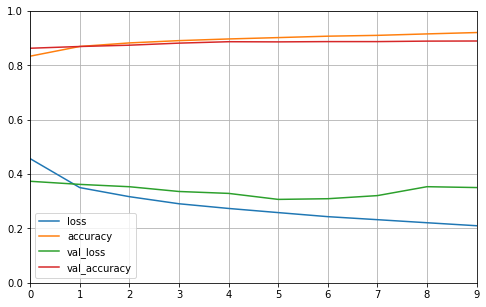

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) 
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

## 4. 测试数据

In [7]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3709085215836763, 0.8848]

## 5.存储并查看saved_model模型

### 5.1 存储模型

In [9]:
path = "./keras_saved_graph"
if not os.path.exists(path):
    os.mkdir(path)
tf.saved_model.save(model, path)

INFO:tensorflow:Assets written to: ./keras_saved_graph\assets


### 5.2 使用命令行工具查看并检测模型

In [30]:
# 查看模型的输入信息，输出信息
!saved_model_cli show --dir ./keras_saved_graph --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: serving_default_flatten_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [32]:
!saved_model_cli show --dir ./keras_saved_graph --tag_set serve \
--signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [34]:
# 测试saved_model是否可以正常工作
!saved_model_cli run --dir ./keras_saved_graph --tag_set serve \
--signature_def serving_default \
--input_exprs "flatten_input=np.ones((2, 28, 28))"

Result for output key dense_2:
[[9.1893063e-15 2.8590177e-26 2.9524076e-18 2.2278671e-22 1.1058861e-15
  5.7308443e-19 3.1200655e-18 7.1351786e-17 1.0000000e+00 8.8453238e-24]
 [9.1893063e-15 2.8590177e-26 2.9524076e-18 2.2278671e-22 1.1058861e-15
  5.7308443e-19 3.1200655e-18 7.1351786e-17 1.0000000e+00 8.8453238e-24]]


2020-01-10 22:32:57.469121: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


### 5.3 加载saved_model模型并检测模型是否能正常工作

In [22]:
# 加载模型
loaded_saved_model = tf.saved_model.load("./keras_saved_graph")
print(list(loaded_saved_model.signatures.keys()))

['serving_default']


In [35]:
# 查看模型
inference = loaded_saved_model.signatures["serving_default"] # 获取一个函数句柄
print(inference)
print(inference.structured_outputs)

{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [36]:
# 测试saved_model模型
results = inference(tf.constant(x_test_scaled[0:1]))
# results = inference(x_test_scaled[0:1])
print(results)
print(results["dense_2"])

{'dense_2': <tf.Tensor: id=60254, shape=(1, 10), dtype=float32, numpy=
array([[1.94735961e-08, 1.35778794e-06, 1.87272797e-09, 2.25595204e-06,
        1.19427686e-08, 3.56057822e-03, 4.18925680e-07, 2.78440770e-03,
        5.45324035e-08, 9.93650973e-01]], dtype=float32)>}
tf.Tensor(
[[1.94735961e-08 1.35778794e-06 1.87272797e-09 2.25595204e-06
  1.19427686e-08 3.56057822e-03 4.18925680e-07 2.78440770e-03
  5.45324035e-08 9.93650973e-01]], shape=(1, 10), dtype=float32)
